In [1]:
import datetime
import sys
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense

In [2]:
# tf.config.threading.set_intra_op_parallelism_threads(
#     7
# )
# tf.config.threading.set_inter_op_parallelism_threads(
#     7
# )

print(tf.__version__)

2.3.2


# Contents
- [Load data](#Load-data)
- [NLP model](#NLP-Model)
- [Investigating saliency](#Investigating-saliency)

# Load data

In [3]:
data_file = Path("/home/alexander/projects/car_data_analysis/final_project_data/deduped_data.csv")

data = pd.read_csv(data_file)
data = data[["id","desc","price"]]

train, test = train_test_split(data, test_size=0.3)

train["test"] = 0
test["test"] = 1

data = pd.concat((train, test))
data.head()

<ipython-input-3-1b82fc2987f8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["test"] = 0
<ipython-input-3-1b82fc2987f8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["test"] = 1


,id,desc,price,test
33256,155-57,"Grey, 3 owners, £7,300",7300,0
8996,46-337,WE ARE A LOCAL FAMILY RUN BUSINESS FOR OVER 38...,2799,0
28827,137-397,"One owner from new, Full Kia service history, ...",9990,0
7442,37-140,"Black, 2 owners, £8,350",8350,0
21091,94-185,Just arrived into stock with a MOT until March...,3500,0


# NLP Model

In [146]:
def lower_strip_punc_and_no_nums(inputs):
    lowercase_inputs = tf.strings.lower(inputs)
    DEFAULT_STRIP_REGEX = r'[!"#$£%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']'
    inputs = tf.strings.regex_replace(lowercase_inputs, DEFAULT_STRIP_REGEX, "")
    inputs = tf.strings.regex_replace(inputs, r"[0-9]*", "")
    return inputs

VOCAB_SIZE = 5000

text_input = Input(shape=(), dtype=tf.string, name='text')
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(output_mode='tf-idf', max_tokens=VOCAB_SIZE, standardize=lower_strip_punc_and_no_nums)
encoder.adapt(train["desc"].values)
net = encoder(text_input)
net = Dense(64, activation="relu")(net)
net = Dense(32, activation="relu")(net)
net = Dense(1, activation="relu")(net)

model = tf.keras.Model(text_input, net)

In [147]:
model.summary()


Model: "functional_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None,)]                 0         
_________________________________________________________________
text_vectorization_4 (TextVe (None, 5000)              0         
ctorization)                                                     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                320064    
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 327,177
Trainable params: 322,177
Non-trainable params: 5,000
_________________________________________________________________


In [148]:
BATCH_SIZE = 64
STEPS_PER_EPOCH = len(train) // BATCH_SIZE
boundaries = [30*STEPS_PER_EPOCH, 50*STEPS_PER_EPOCH]
values = [0.001, 1e-5, 1e-8]
lr = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

loss = keras.losses.MeanSquaredError()
optim = tf.keras.optimizers.RMSprop(learning_rate=lr)

model.compile(loss=loss, optimizer=optim)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1, restore_best_weights=True)

In [149]:
start = datetime.datetime.now()
history = model.fit(train["desc"].values, 
                    train["price"].values,
                    epochs=100,
                    batch_size=BATCH_SIZE,
                    validation_data=(test["desc"].values, test["price"].values),
                    callbacks=[early_stopping],
                    verbose=1,
                   )
end = datetime.datetime.now()
time_elapsed = (end - start).total_seconds()
time_elapsed

Epoch 1/100
381/381 [==============================] - 23s 61ms/step - loss: 25127120.0000 - val_loss: 16814172.0000
Epoch 2/100
381/381 [==============================] - 23s 61ms/step - loss: 14172667.0000 - val_loss: 12081337.0000
Epoch 3/100
381/381 [==============================] - 23s 61ms/step - loss: 10283489.0000 - val_loss: 9505481.0000
Epoch 4/100
381/381 [==============================] - 23s 62ms/step - loss: 8161285.0000 - val_loss: 7978200.0000
Epoch 5/100
381/381 [==============================] - 23s 62ms/step - loss: 6706377.0000 - val_loss: 6899317.5000
Epoch 6/100
381/381 [==============================] - 23s 61ms/step - loss: 5723195.0000 - val_loss: 6265455.0000
Epoch 7/100
381/381 [==============================] - 23s 61ms/step - loss: 5091779.0000 - val_loss: 5904862.5000
Epoch 8/100
381/381 [==============================] - 23s 61ms/step - loss: 4693066.5000 - val_loss: 5703267.5000
Epoch 9/100
381/381 [==============================] - 23s 62ms/step - loss

713.474994

# Investigating saliency

## Retrieve some samples from data and encode

In [150]:
train_desc = tf.constant(data[data["test"]==0].iloc[2]["desc"])
train_desc_batched = tf.expand_dims(tf.constant(train_desc), axis=0)
test_desc = tf.constant(data[data["test"]==1].iloc[4]["desc"])
test_desc_batched = tf.expand_dims(tf.constant(test_desc), axis=0)
print(train_desc.numpy())
print("-"*100)
print(test_desc.numpy())

b'One owner from new, Full Kia service history, Balance of Kia warranty till August 2024, Guaranteed Mileage, All vehicles HPi checked, Always low prices. Southwick Car Centre is located in the village of Southwick near Trowbridge in Wiltshire on the A361 within 20 minutes of Westbury, Warminster, Frome, Bath, Melksham, Chippenham and 40 minutes from Bristol, Swindon, Salisbury and the M4 (post code for sat nav BA149QN). We stock up to 100 quality one owner vehicles with full manufacturer service history. Established in 1996 we have over 23 years experience in used vehicle sales. We open Monday - Friday 09.00-17.00 and Sat 09.00-15.00. All major credit and debit cards accepted, Competitive finance packages available please click through to our website for further details and to use our online finance calculator. Cars price matched daily to guarantee we always offer an exceptionally competitive price. , For more information about one of our vehicles, to book a viewing, test drive or to 

In [151]:
train_encoding = encoder(train_desc_batched)
verify_encoding = encoder(train_desc)
test_encoding = encoder(test_desc_batched)
print(train_encoding)
print(test_encoding)

tf.Tensor([[6.498942  5.3134384 7.151007  ... 0.        0.        0.       ]], shape=(1, 5000), dtype=float32)
tf.Tensor([[2.7852607 0.8855731 2.043145  ... 0.        0.        0.       ]], shape=(1, 5000), dtype=float32)


### Verify encoder works

In [185]:
vocab = encoder.get_vocabulary()

def index_encoding(text, encoder):
    indices = []
    for word in text.decode("UTF-8").split(" "):
        encoding = encoder(word).numpy()
        non_zero = np.nonzero(encoding)
        print(non_zero)
        if len(non_zero) == 2:
            index = int(non_zero[1][0])
        elif len(non_zero) == 1:
            index = 0
        else:
            raise ValueError()
            
        indices.append(index)        
    return indices
            
for word in verify_encoding.numpy():
    non_zero_entries, indices = count_and_find_non_zero(word)
    assert non_zero_entries == 1
    index = indices[0]
    seen_by_network.append((vocab[index], index))
    print(vocab[index] , end=" ")
    
index_encoding(train_desc.numpy(), encoder)


one owner from new full kia service history balance of kia warranty till august guaranteed mileage all vehicles hpi checked always low prices southwick car centre is located in the village of southwick near [UNK] in wiltshire on the a within minutes of [UNK] [UNK] [UNK] bath [UNK] [UNK] and minutes from bristol swindon salisbury and the m post code for sat nav [UNK] we stock up to quality one owner vehicles with full manufacturer service history established in we have over years experience in used vehicle sales we open monday friday and sat all major credit and debit cards accepted competitive finance packages available please click through to our website for further details and to use our online finance calculator cars price matched daily to guarantee we always offer an exceptionally competitive price for more information about one of our vehicles to book a viewing test drive or to reserve a vehicle please call our sales centre on southwick car centre offering an honest friendly servi

IndexError: index 0 is out of bounds for axis 0 with size 0

## Retrieve trained Dense layers - as we want saliency on encoded words

In [153]:
encoded_input = Input(shape=(5000,))
net = encoded_input

for layer in model.layers[-3:]:
    net = layer(net)
saliency_model = tf.keras.Model(encoded_input, net)
saliency_model.summary()

Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 5000)]            0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                320064    
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 322,177
Trainable params: 322,177
Non-trainable params: 0
_________________________________________________________________


In [169]:
saliency_res = saliency_model(train_encoding)
model_res = model(train_desc_batched)
print(saliency_res)
print(model_res)

tf.Tensor([[10114.734]], shape=(1, 1), dtype=float32)
tf.Tensor([[10114.734]], shape=(1, 1), dtype=float32)


In [155]:
with tf.GradientTape() as tape:
    tape.watch(train_encoding)
    tape.watch(train_desc_batched)
    saliency_res = saliency_model(train_encoding)
    model_res = model(train_desc_batched)

encoded_saliency = tape.gradient(saliency_res, train_encoding).numpy()[0]
print(encoded_saliency)
# direct_saliency = tape.gradient(model_res, train_desc_batched)

[ 48.61583    30.870617  -10.390949  ...  -1.5274127 -41.0732
 125.80129  ]


In [170]:
def map_to_unit(grads):
    _max = grads.max()
    print(_max)
    _min = grads.min()
    print(_min)
    return [(grad-_min)/(_max- _min) for grad in grads]

highlight_intensity = map_to_unit(encoded_saliency)

840.422
-302.91544


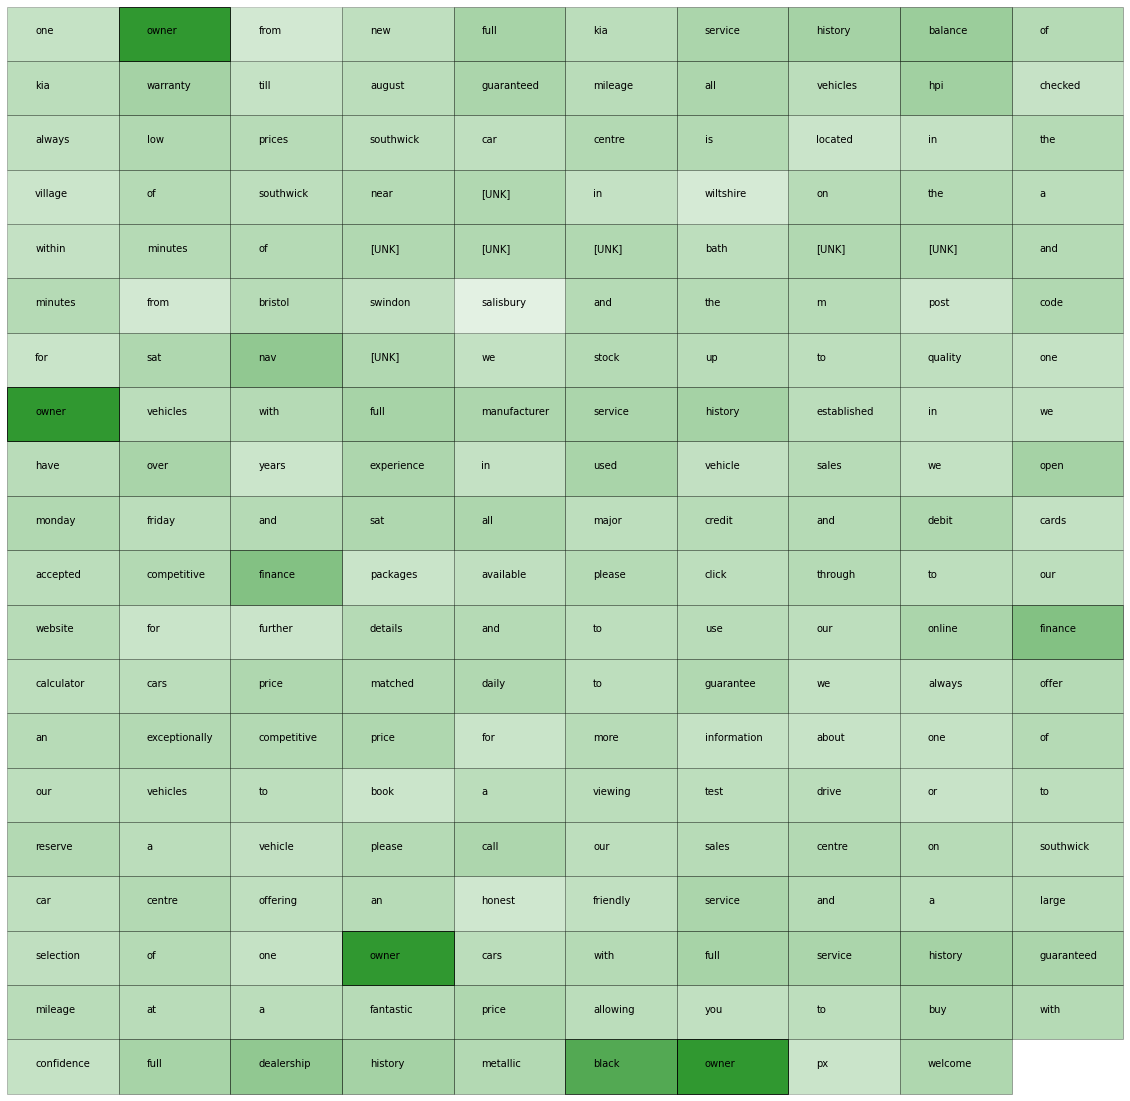

In [168]:
text, indices = list(zip(*seen_by_network))
alphas = [highlight_intensity[idx] for idx in indices]

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from typing import Iterable

def text_saliency(text: Iterable, alphas: Iterable, height=None, width=20, word_width=2):
    if height is None:
        height = len(text)//(width//word_width) + 1
    
    def highlight(x, y, intensity=0.2, word_width=word_width):
        pc = [Rectangle((x-0.5, y-0.5), word_width, 1)]
        pc = PatchCollection(pc, facecolor="g", alpha=intensity,
                             edgecolor="black")
        plt.gca().add_collection(pc)
    
    plt.figure(figsize=(width,height))
    plt.axis("off")
    plt.axis([0, width, 0, height])
    loc = [0.5, height-0.5]
    for word, alpha in zip(text, alphas):
        highlight(*loc, intensity=alpha)
        loc = list(plt.text(*loc, word).get_position())
        loc[0] += word_width
        if loc[0] > width:
            loc[0] = 0.5
            loc[1] -=1

text_saliency(text, alphas)